##Optional

Add in results from the original model

It is already cached on Optimum Neuron, so we don't need to compile it.

In [1]:
import os
import json
from vllm import LLM, SamplingParams
import re

# Load the ORIGINAL base model (not fine-tuned)
print("Loading original base model: Qwen/Qwen3-0.6B")
llm_base = LLM(
    model="Qwen/Qwen3-0.6B",
    max_num_seqs=1,
    max_model_len=2048,
    tensor_parallel_size=2,
)

def create_conversation(input_text):
    """Create conversation format matching the training script."""
    return [
        {
            "role": "system",
            "content": "Classify the better move. Output format: MoveA or MoveB"
        },
        {
            "role": "user",
            "content": input_text
        },
    ]

def extract_move_answer(text):
    """Extract MoveA or MoveB from the generated text - looking at the END of the text."""
    # Look at the last 200 characters where the answer should be
    text_end = text[-200:] if len(text) > 200 else text
    
    # Look for MoveA or MoveB (case insensitive, with optional colon and move notation)
    match = re.search(r'Move([AB])(?::[a-z0-9]+)?', text_end, re.IGNORECASE)
    if match:
        return f"MOVE{match.group(1).upper()}"
    
    # If not found at the end, search the whole text (take the LAST occurrence)
    matches = list(re.finditer(r'Move([AB])(?::[a-z0-9]+)?', text, re.IGNORECASE))
    if matches:
        return f"MOVE{matches[-1].group(1).upper()}"
    
    return None

def normalize_expected_answer(expected_output):
    """Normalize the expected answer to just MOVEA or MOVEB."""
    match = re.search(r'Move([AB])', expected_output, re.IGNORECASE)
    if match:
        return f"MOVE{match.group(1).upper()}"
    return expected_output.upper()

# Load the chess dataset
print("Loading chess dataset...")
with open('/home/ubuntu/environment/distillation/data/chess_output.json', 'r') as f:
    chess_data = json.load(f)

# Filter out samples with errors
chess_data = [item for item in chess_data if 'error' not in item]
print(f"Loaded {len(chess_data)} valid chess samples")

# Create prompts using the tokenizer's chat template
from transformers import AutoTokenizer
tokenizer_base = AutoTokenizer.from_pretrained("Qwen/Qwen3-0.6B")

prompts = []
for item in chess_data:
    conversation = create_conversation(item['input'])
    formatted_prompt = tokenizer_base.apply_chat_template(
        conversation,
        tokenize=False,
        add_generation_prompt=True
    )
    prompts.append(formatted_prompt)

print(f"Created {len(prompts)} prompts for inference")

# Run inference with full sequence length
print("\nRunning inference on original base model...")
print("Using max_tokens=2048 to ensure complete responses")
sampling_params = SamplingParams(max_tokens=2048, temperature=0.0)
outputs_base = llm_base.generate(prompts, sampling_params)

# Process results
results_base = []
base_correct = 0

for idx, output in enumerate(outputs_base):
    item = chess_data[idx]
    generated_text = output.outputs[0].text.strip()
    
    # Extract the base model's answer
    base_answer = extract_move_answer(generated_text)
    
    # Get the expected (correct) answer and normalize it
    expected_answer = normalize_expected_answer(item['expected_output'])
    
    # Check correctness
    base_is_correct = (base_answer == expected_answer) if base_answer else False
    
    if base_is_correct:
        base_correct += 1
    
    results_base.append({
        'question_id': idx,
        'base_answer': base_answer,
        'base_correct': base_is_correct,
        'base_raw_output': generated_text
    })
    
    # Print progress every 100 samples
    if (idx + 1) % 100 == 0:
        print(f"Processed {idx + 1}/{len(chess_data)} samples...")
        print(f"  Current Base Model Accuracy: {base_correct}/{idx+1} ({base_correct/(idx+1)*100:.1f}%)")

# Calculate statistics
total_samples = len(results_base)
base_accuracy = (base_correct / total_samples) * 100

# Save base model results
base_summary = {
    'total_samples': total_samples,
    'base_correct': base_correct,
    'base_accuracy': base_accuracy,
    'results': results_base
}

output_file = 'chess_evaluation_base_model.json'
with open(output_file, 'w') as f:
    json.dump(base_summary, f, indent=2)

print(f"\n{'='*80}")
print(f"Base Model Evaluation Complete!")
print(f"{'='*80}")
print(f"Total Samples: {total_samples}")
print(f"Base Model Accuracy: {base_correct}/{total_samples} ({base_accuracy:.2f}%)")
print(f"\nResults saved to: {output_file}")


INFO 11-07 18:27:34 [__init__.py:36] Available plugins for group vllm.platform_plugins:
INFO 11-07 18:27:34 [__init__.py:38] - optimum_neuron -> optimum.neuron.vllm.plugin:register
INFO 11-07 18:27:35 [__init__.py:41] All plugins in this group will be loaded. Set `VLLM_PLUGINS` to control which plugins to load.
INFO 11-07 18:27:35 [__init__.py:207] Platform plugin optimum_neuron is activated
WARNING 11-07 18:27:36 [_custom_ops.py:20] Failed to import from vllm._C with ImportError('libcuda.so.1: cannot open shared object file: No such file or directory')
Loading original base model: Qwen/Qwen3-0.6B
INFO 11-07 18:27:36 [utils.py:328] non-default args: {'max_model_len': 2048, 'tensor_parallel_size': 2, 'max_num_seqs': 1, 'disable_log_stats': True}
INFO 11-07 18:27:46 [__init__.py:742] Resolved architecture: Qwen3ForCausalLM
INFO 11-07 18:27:46 [__init__.py:1815] Using max model len 2048
WARNING 11-07 18:27:46 [arg_utils.py:1801] device type=cpu is not supported by the V1 Engine. Falling b

/opt/aws_neuronx_venv_pytorch_latest/lib/python3.10/site-packages/neuronx_distributed/parallel_layers/layers.py:14: DeprecationWarning: torch_neuronx.nki_jit is deprecated, use nki.jit instead.
  from .mappings import (
/opt/aws_neuronx_venv_pytorch_latest/lib/python3.10/site-packages/neuronx_distributed/parallel_layers/layers.py:14: DeprecationWarning: torch_neuronx.nki_jit is deprecated, use nki.jit instead.
  from .mappings import (
/opt/aws_neuronx_venv_pytorch_latest/lib/python3.10/site-packages/neuronx_distributed/parallel_layers/layers.py:14: DeprecationWarning: torch_neuronx.nki_jit is deprecated, use nki.jit instead.
  from .mappings import (
/opt/aws_neuronx_venv_pytorch_latest/lib/python3.10/site-packages/neuronx_distributed/modules/moe/blockwise.py:68: DeprecationWarning: torch_neuronx.nki_jit is deprecated, use nki.jit instead.
  component, error = import_nki(config)
/opt/aws_neuronx_venv_pytorch_latest/lib/python3.10/site-packages/neuronx_distributed/modules/moe/blockwise

[Gloo] Rank 0 is connected to 0 peer ranks. Expected number of connected peer ranks is : 0
[Gloo] Rank 0 is connected to 0 peer ranks. Expected number of connected peer ranks is : 0
[Gloo] Rank 0 is connected to 0 peer ranks. Expected number of connected peer ranks is : 0
[Gloo] Rank 0 is connected to 0 peer ranks. Expected number of connected peer ranks is : 0
[Gloo] Rank 0 is connected to 0 peer ranks. Expected number of connected peer ranks is : 0
[Gloo] Rank 0 is connected to 0 peer ranks. Expected number of connected peer ranks is : 0
[Gloo] Rank 0 is connected to 0 peer ranks. Expected number of connected peer ranks is : 0
[Gloo] Rank 0 is connected to 0 peer ranks. Expected number of connected peer ranks is : 0
[Gloo] Rank 0 is connected to 0 peer ranks. Expected number of connected peer ranks is : 0
[Gloo] Rank 0 is connected to 0 peer ranks. Expected number of connected peer ranks is : 0
[Gloo] Rank 0 is connected to 0 peer ranks. Expected number of connected peer ranks is : 0

0ba272c346484c8aefe4.json: 0.00B [00:00, ?B/s]

185dc25476a38ba54c23.json: 0.00B [00:00, ?B/s]

e559e923dc1063538738.json: 0.00B [00:00, ?B/s]

87d7a742d30507d3f69d.json: 0.00B [00:00, ?B/s]

d57ce22671d402caf93b.json: 0.00B [00:00, ?B/s]

45c08ef2b6c578463757.json: 0.00B [00:00, ?B/s]

eebb6c46f5bf791df0bc.json: 0.00B [00:00, ?B/s]

02bdaf31b9717fc1c0cb.json: 0.00B [00:00, ?B/s]

62e8185571838c35beb5.json: 0.00B [00:00, ?B/s]

aaed6c5a23a67df97a96.json: 0.00B [00:00, ?B/s]

e942d1bd7f83c277445b.json: 0.00B [00:00, ?B/s]

7805d8ee5618821c65f9.json: 0.00B [00:00, ?B/s]

9467fb64a9b1998240df.json: 0.00B [00:00, ?B/s]

99e47918d58c852b7ba6.json: 0.00B [00:00, ?B/s]

ad6425afc61bc911f872.json: 0.00B [00:00, ?B/s]

bcbff30a76ff16a31f78.json: 0.00B [00:00, ?B/s]

8831721db04a7eff0a7e.json: 0.00B [00:00, ?B/s]

ce85ff6d82b8dd552c97.json: 0.00B [00:00, ?B/s]

1292d119c7ec669774b1.json: 0.00B [00:00, ?B/s]

1ec8b3aae0163ae268ad.json: 0.00B [00:00, ?B/s]

24bbe4e6529b12c595f3.json: 0.00B [00:00, ?B/s]

265c731e3c5a9fb1f956.json: 0.00B [00:00, ?B/s]

4238363f859e9873f814.json: 0.00B [00:00, ?B/s]

58af89a5e613c876fbf9.json: 0.00B [00:00, ?B/s]

a256f816e8ad645fad64.json: 0.00B [00:00, ?B/s]

0c0d94fdf54794ef5a73.json: 0.00B [00:00, ?B/s]

2438be162acfdae5dc19.json: 0.00B [00:00, ?B/s]

7fbf409eea4fd3fa0cfc.json: 0.00B [00:00, ?B/s]

/opt/aws_neuronx_venv_pytorch_latest/lib/python3.10/site-packages/optimum/neuron/models/inference/llama/modeling_llama.py:33: DeprecationWarning: torch_neuronx.nki_jit is deprecated, use nki.jit instead.
  from ..backend.modules.attention.attention_base import NeuronAttentionBase
INFO:Neuron:Generating HLOs for the following models: ['context_encoding', 'token_generation']


[2025-11-07 18:28:06.688: I neuronx_distributed/parallel_layers/parallel_state.py:630] > initializing tensor model parallel with size 2
[2025-11-07 18:28:06.689: I neuronx_distributed/parallel_layers/parallel_state.py:631] > initializing pipeline model parallel with size 1
[2025-11-07 18:28:06.690: I neuronx_distributed/parallel_layers/parallel_state.py:632] > initializing context model parallel with size 1
[2025-11-07 18:28:06.691: I neuronx_distributed/parallel_layers/parallel_state.py:633] > initializing data parallel with size 1
[2025-11-07 18:28:06.692: I neuronx_distributed/parallel_layers/parallel_state.py:634] > initializing world size to 2
[2025-11-07 18:28:06.692: I neuronx_distributed/parallel_layers/parallel_state.py:379] [rank_0_pp-1_tp-1_dp-1_cp-1] Chosen Logic for replica groups ret_logic=<PG_Group_Logic.LOGIC1: (<function ascending_ring_PG_group at 0x7dfc1cee2cb0>, 'Ascending Ring PG Group')>
[2025-11-07 18:28:06.694: I neuronx_distributed/parallel_layers/parallel_state

INFO:Neuron:Generating 1 hlos for key: context_encoding
INFO:Neuron:Started loading module context_encoding
INFO:Neuron:Finished loading module context_encoding in 0.3675663471221924 seconds
INFO:Neuron:generating HLO: context_encoding, input example shape = torch.Size([1, 2048])
/opt/aws_neuronx_venv_pytorch_latest/lib/python3.10/site-packages/neuronx_distributed/parallel_layers/layers.py:507: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
/opt/aws_neuronx_venv_pytorch_latest/lib/python3.10/site-packages/optimum/neuron/models/inference/backend/modules/generation/sampling.py:299: DeprecationWarning: torch_neuronx.nki_jit is deprecated, use nki.jit instead.
  probs_cumsum = cumsum(tensor_in=probs_soft_max, dim=dim, on_cpu=self.on_cpu)
/opt/aws_neuronx_venv_pytorch_latest/lib/python3.10/site-packages/optimum/neuron/models/inference/backend/modules/generation/sampling

2025-11-07 18:28:26.000854:  362752  INFO ||NEURON_CC_WRAPPER||: Using a cached neff at /var/tmp/neuron-compile-cache/neuronxcc-2.21.18209.0+043b1bf7/MODULE_9065361bd1d6056abc4d+ac10809c/model.neff


/opt/aws_neuronx_venv_pytorch_latest/lib/python3.10/site-packages/libneuronxla/neuron_cc_wrapper.py:283: SyntaxWarning: str format compiler_flags is discouraged as its handling involves repeated joining and splitting, which can easily make mistakes if something is quoted or escaped. Use list[str] instead. Refer to documentation of the Python subprocess module for details.
  warnings.warn(SyntaxWarning(
INFO:Neuron:Done compilation for the priority HLO in 0.4350917339324951 seconds
INFO:Neuron:Updating the hlo module with optimized layout
INFO:Neuron:Done optimizing weight layout for all HLOs in 0.41043901443481445 seconds
INFO:Neuron:Starting compilation for all HLOs
INFO:Neuron:Neuron compiler flags: --auto-cast=none --model-type=transformer --tensorizer-options='--enable-ccop-compute-overlap --cc-pipeline-tiling-factor=2 --vectorize-strided-dma ' -O2  --lnc=2 --target trn2 --logfile=/tmp/nxd_model/context_encoding/_tp0_bk0/log-neuron-cc.txt
/opt/aws_neuronx_venv_pytorch_latest/lib/py

2025-11-07 18:28:27.000858:  362752  INFO ||NEURON_CC_WRAPPER||: Using a cached neff at /var/tmp/neuron-compile-cache/neuronxcc-2.21.18209.0+043b1bf7/MODULE_678e7843ed934a86c65b+a32116a7/model.neff


INFO:Neuron:Finished Compilation for all HLOs in 0.5761351585388184 seconds


..Completed run_backend_driver.

Compiler status PASS


INFO:Neuron:Done preparing weight layout transformation
INFO:Neuron:Finished building model in 54.11144185066223 seconds


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:Neuron:There are no saved sharded checkpoints.
INFO:Neuron:Sharding Weights for ranks: 0...1


[2025-11-07 18:29:01.054: I neuronx_distributed/parallel_layers/parallel_state.py:630] > initializing tensor model parallel with size 2
[2025-11-07 18:29:01.054: I neuronx_distributed/parallel_layers/parallel_state.py:631] > initializing pipeline model parallel with size 1
[2025-11-07 18:29:01.055: I neuronx_distributed/parallel_layers/parallel_state.py:632] > initializing context model parallel with size 1
[2025-11-07 18:29:01.055: I neuronx_distributed/parallel_layers/parallel_state.py:633] > initializing data parallel with size 1
[2025-11-07 18:29:01.056: I neuronx_distributed/parallel_layers/parallel_state.py:634] > initializing world size to 2
[2025-11-07 18:29:01.056: I neuronx_distributed/parallel_layers/parallel_state.py:379] [rank_0_pp-1_tp-1_dp-1_cp-1] Chosen Logic for replica groups ret_logic=<PG_Group_Logic.LOGIC1: (<function ascending_ring_PG_group at 0x7dfc1cee2cb0>, 'Ascending Ring PG Group')>
[2025-11-07 18:29:01.057: I neuronx_distributed/parallel_layers/parallel_state

/opt/aws_neuronx_venv_pytorch_latest/lib/python3.10/site-packages/neuronx_distributed/trace/trace.py:642: UserWarning: Removing redundant keys from checkpoint: []
  warnings.warn(f"Removing redundant keys from checkpoint: {keys_to_delete}")
INFO:Neuron:Done Sharding weights in 4.092413285005023


WARNING 11-07 18:29:20 [__init__.py:3804] Current vLLM config is not set.
WARNING 11-07 18:29:20 [__init__.py:3804] Current vLLM config is not set.
INFO 11-07 18:29:20 [executor_base.py:114] # neuron blocks: 2, # CPU blocks: 0
INFO 11-07 18:29:20 [executor_base.py:119] Maximum concurrency for 2048 tokens per request: 2.00x
INFO 11-07 18:29:20 [llm_engine.py:420] init engine (profile, create kv cache, warmup model) took 0.00 seconds
INFO 11-07 18:29:20 [importing.py:43] Triton is installed but 0 active driver(s) found (expected 1). Disabling Triton to prevent runtime errors.
INFO 11-07 18:29:20 [importing.py:63] Triton not installed or not compatible; certain GPU-related functions will not be available.
INFO 11-07 18:29:20 [llm.py:295] Supported_tasks: ['generate']
INFO 11-07 18:29:20 [__init__.py:36] No IOProcessor plugins requested by the model
Loading chess dataset...
Loaded 100 valid chess samples
Created 100 prompts for inference

Running inference on original base model...
Using m

Adding requests:   0%|          | 0/100 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/100 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

2025-Nov-07 18:29:21.0210 362752:363008 [1] int nccl_net_ofi_create_plugin(nccl_net_ofi_plugin_t**):219 CCOM WARN NET/OFI Failed to initialize rdma protocol
2025-Nov-07 18:29:21.0216 362752:363008 [1] int nccl_net_ofi_create_plugin(nccl_net_ofi_plugin_t**):354 CCOM WARN NET/OFI aws-ofi-nccl initialization failed
2025-Nov-07 18:29:21.0219 362752:363008 [1] ncclResult_t nccl_net_ofi_init_no_atexit_fini_v6(ncclDebugLogger_t):183 CCOM WARN NET/OFI Initializing plugin failed
2025-Nov-07 18:29:21.0221 362752:363008 [1] net_plugin.cc:97 CCOM WARN OFI plugin initNet() failed is EFA enabled?
Processed 100/100 samples...
  Current Base Model Accuracy: 48/100 (48.0%)

Base Model Evaluation Complete!
Total Samples: 100
Base Model Accuracy: 48/100 (48.00%)

Results saved to: chess_evaluation_base_model.json


In [2]:
import json

# Load all three result files
print("Merging results from all three models...")

# Load fine-tuned student results
with open('chess_evaluation_results.json', 'r') as f:
    student_data = json.load(f)

# Load base model results
with open('chess_evaluation_base_model.json', 'r') as f:
    base_data = json.load(f)

# Merge the results
merged_results = []
for i in range(len(student_data['results'])):
    student_result = student_data['results'][i]
    base_result = base_data['results'][i]
    
    merged_results.append({
        'question_id': i,
        'input': student_result['input'],
        'expected_answer': student_result['expected_answer'],
        'teacher_answer': student_result['teacher_answer'],
        'teacher_correct': student_result['teacher_correct'],
        'base_answer': base_result['base_answer'],
        'base_correct': base_result['base_correct'],
        'student_answer': student_result['student_answer'],
        'student_correct': student_result['student_correct'],
        'base_raw_output': base_result['base_raw_output'],
        'student_raw_output': student_result['student_raw_output']
    })

# Create comprehensive summary
comprehensive_summary = {
    'total_samples': student_data['total_samples'],
    'teacher_correct': student_data['teacher_correct'],
    'teacher_accuracy': student_data['teacher_accuracy'],
    'base_correct': base_data['base_correct'],
    'base_accuracy': base_data['base_accuracy'],
    'student_correct': student_data['student_correct'],
    'student_accuracy': student_data['student_accuracy'],
    'results': merged_results
}

# Save comprehensive results
output_file = 'chess_evaluation_comprehensive.json'
with open(output_file, 'w') as f:
    json.dump(comprehensive_summary, f, indent=2)

print(f"\n{'='*80}")
print(f"Comprehensive Results Summary")
print(f"{'='*80}")
print(f"Total Samples: {comprehensive_summary['total_samples']}")
print(f"\nTeacher (Qwen3-30B):     {comprehensive_summary['teacher_correct']}/{comprehensive_summary['total_samples']} ({comprehensive_summary['teacher_accuracy']:.2f}%)")
print(f"Base (Qwen3-0.6B):       {comprehensive_summary['base_correct']}/{comprehensive_summary['total_samples']} ({comprehensive_summary['base_accuracy']:.2f}%)")
print(f"Student (Fine-tuned):    {comprehensive_summary['student_correct']}/{comprehensive_summary['total_samples']} ({comprehensive_summary['student_accuracy']:.2f}%)")
print(f"\nImprovement over base:   {comprehensive_summary['student_accuracy'] - comprehensive_summary['base_accuracy']:.2f} percentage points")
print(f"\nResults saved to: {output_file}")


Merging results from all three models...

Comprehensive Results Summary
Total Samples: 100

Teacher (Qwen3-30B):     59/100 (59.00%)
Base (Qwen3-0.6B):       48/100 (48.00%)
Student (Fine-tuned):    51/100 (51.00%)

Improvement over base:   3.00 percentage points

Results saved to: chess_evaluation_comprehensive.json


CHESS MOVE EVALUATION RESULTS - THREE MODEL COMPARISON

Dataset Size: 100 chess positions

Model                     Correct         Incorrect       Accuracy       
--------------------------------------------------------------------------------
Teacher (Qwen3-30B)       59              41              59.00%
Base (Qwen3-0.6B)         48              52              48.00%
Student (Fine-tuned)      51              49              51.00%
--------------------------------------------------------------------------------

🎯 Fine-tuning Improvement: +3.00 percentage points
   (+3 more correct answers)

📚 Knowledge Transfer: 27.3%
   (Captured 27.3% of the gap between base and teacher)

Visualization saved to: chess_evaluation_comprehensive.png


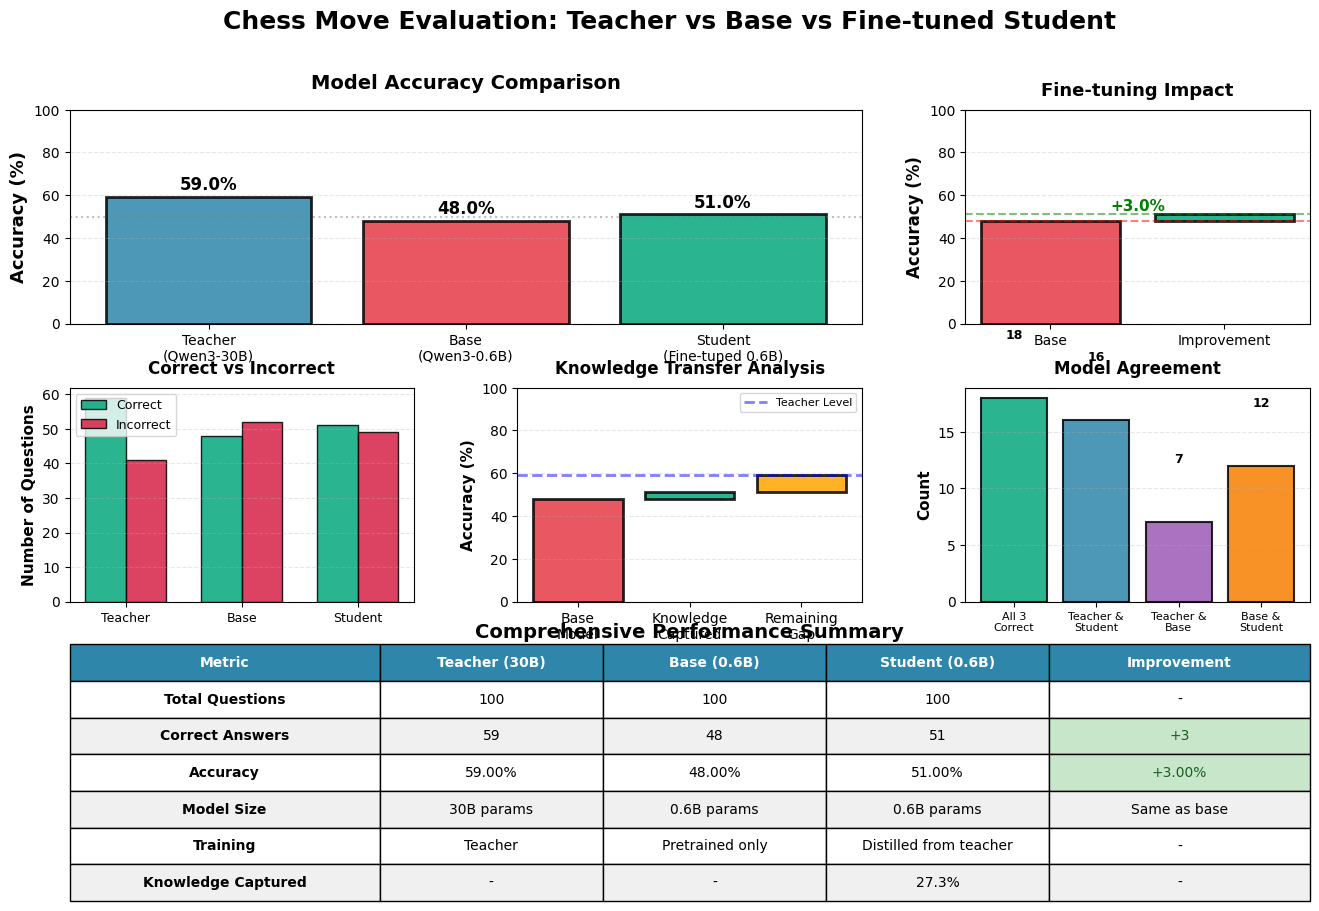


SAMPLE PREDICTIONS (First 5 questions)

Question 1:
  Input: The FEN of the given chess board is "1r4k1/4nppp/8/4Pb2/8/1P5P/r1PR4/3R3K w - - 0 27". Which move is...
  Expected: MOVEA
  Teacher:  MOVEA ✓
  Base:     MOVEA ✓
  Student:  MOVEA ✓

Question 2:
  Input: The FEN of the given chess board is "7r/pp4k1/8/3p1pp1/3N1q2/2P4P/PP4Q1/6K1 w - - 0 39". Which move ...
  Expected: MOVEB
  Teacher:  MOVEB ✓
  Base:     MOVEA ✗
  Student:  MOVEA ✗

Question 3:
  Input: The FEN of the given chess board is "4k2r/p4ppp/2p3P1/2b1P2n/8/P1N5/1P1rQ1PP/R4R1K b k - 0 20". Whic...
  Expected: MOVEB
  Teacher:  MOVEA ✗
  Base:     MOVEA ✗
  Student:  MOVEA ✗

Question 4:
  Input: The FEN of the given chess board is "2r3k1/rb3pp1/p1q1p2p/2N5/3P4/p1PQP3/5PPP/3R1RK1 b - - 3 25". Wh...
  Expected: MOVEB
  Teacher:  MOVEB ✓
  Base:     MOVEA ✗
  Student:  MOVEA ✗

Question 5:
  Input: The FEN of the given chess board is "8/5Bpk/7p/pp6/qP6/P1Qb2P1/5PKP/8 b - - 1 30". Which move is bet...
  Expected: MOVEA


In [3]:
import json
import matplotlib.pyplot as plt
import numpy as np

# Load the comprehensive results
with open('chess_evaluation_comprehensive.json', 'r') as f:
    data = json.load(f)

# Extract statistics
total_samples = data['total_samples']
teacher_correct = data['teacher_correct']
teacher_accuracy = data['teacher_accuracy']
base_correct = data['base_correct']
base_accuracy = data['base_accuracy']
student_correct = data['student_correct']
student_accuracy = data['student_accuracy']

# Print detailed statistics
print("="*80)
print("CHESS MOVE EVALUATION RESULTS - THREE MODEL COMPARISON")
print("="*80)
print(f"\nDataset Size: {total_samples} chess positions")
print(f"\n{'Model':<25} {'Correct':<15} {'Incorrect':<15} {'Accuracy':<15}")
print("-"*80)
print(f"{'Teacher (Qwen3-30B)':<25} {teacher_correct:<15} {total_samples - teacher_correct:<15} {teacher_accuracy:.2f}%")
print(f"{'Base (Qwen3-0.6B)':<25} {base_correct:<15} {total_samples - base_correct:<15} {base_accuracy:.2f}%")
print(f"{'Student (Fine-tuned)':<25} {student_correct:<15} {total_samples - student_correct:<15} {student_accuracy:.2f}%")
print("-"*80)

# Calculate improvement
improvement = student_accuracy - base_accuracy
print(f"\n🎯 Fine-tuning Improvement: {improvement:+.2f} percentage points")
print(f"   ({student_correct - base_correct:+d} more correct answers)")

# Calculate knowledge transfer
knowledge_gap = teacher_accuracy - base_accuracy
knowledge_captured = (student_accuracy - base_accuracy) / knowledge_gap * 100 if knowledge_gap > 0 else 0
print(f"\n📚 Knowledge Transfer: {knowledge_captured:.1f}%")
print(f"   (Captured {knowledge_captured:.1f}% of the gap between base and teacher)")

print("="*80)

# Create visualizations
fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

fig.suptitle('Chess Move Evaluation: Teacher vs Base vs Fine-tuned Student', 
             fontsize=18, fontweight='bold', y=0.98)

# 1. Accuracy Comparison Bar Chart (larger, spanning 2 columns)
ax1 = fig.add_subplot(gs[0, :2])
models = ['Teacher\n(Qwen3-30B)', 'Base\n(Qwen3-0.6B)', 'Student\n(Fine-tuned 0.6B)']
accuracies = [teacher_accuracy, base_accuracy, student_accuracy]
colors = ['#2E86AB', '#E63946', '#06A77D']
bars = ax1.bar(models, accuracies, color=colors, alpha=0.85, edgecolor='black', linewidth=2)
ax1.set_ylabel('Accuracy (%)', fontsize=13, fontweight='bold')
ax1.set_title('Model Accuracy Comparison', fontsize=14, fontweight='bold', pad=15)
ax1.set_ylim(0, 100)
ax1.grid(axis='y', alpha=0.3, linestyle='--')
ax1.axhline(y=50, color='gray', linestyle=':', alpha=0.5, label='Random Guess (50%)')
for bar, acc in zip(bars, accuracies):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 1.5,
             f'{acc:.1f}%', ha='center', va='bottom', fontsize=12, fontweight='bold')

# 2. Improvement Visualization
ax2 = fig.add_subplot(gs[0, 2])
improvement_data = [base_accuracy, student_accuracy - base_accuracy]
colors_imp = ['#E63946', '#06A77D']
ax2.bar(['Base', 'Improvement'], improvement_data, color=colors_imp, alpha=0.85, 
        edgecolor='black', linewidth=2, bottom=[0, base_accuracy])
ax2.set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
ax2.set_title('Fine-tuning Impact', fontsize=13, fontweight='bold', pad=10)
ax2.set_ylim(0, 100)
ax2.axhline(y=base_accuracy, color='red', linestyle='--', alpha=0.5, linewidth=1.5)
ax2.axhline(y=student_accuracy, color='green', linestyle='--', alpha=0.5, linewidth=1.5)
ax2.text(0.5, student_accuracy + 2, f'+{improvement:.1f}%', 
         ha='center', fontsize=11, fontweight='bold', color='green')
ax2.grid(axis='y', alpha=0.3, linestyle='--')

# 3. Correct vs Incorrect Counts
ax3 = fig.add_subplot(gs[1, 0])
x = np.arange(3)
width = 0.35
correct_counts = [teacher_correct, base_correct, student_correct]
incorrect_counts = [total_samples - teacher_correct, total_samples - base_correct, 
                    total_samples - student_correct]
bars1 = ax3.bar(x - width/2, correct_counts, width, label='Correct', 
                color='#06A77D', alpha=0.85, edgecolor='black')
bars2 = ax3.bar(x + width/2, incorrect_counts, width, label='Incorrect', 
                color='#D62246', alpha=0.85, edgecolor='black')
ax3.set_ylabel('Number of Questions', fontsize=11, fontweight='bold')
ax3.set_title('Correct vs Incorrect', fontsize=12, fontweight='bold', pad=10)
ax3.set_xticks(x)
ax3.set_xticklabels(['Teacher', 'Base', 'Student'], fontsize=9)
ax3.legend(fontsize=9)
ax3.grid(axis='y', alpha=0.3, linestyle='--')

# 4. Knowledge Transfer Gauge
ax4 = fig.add_subplot(gs[1, 1])
categories = ['Base\nModel', 'Knowledge\nCaptured', 'Remaining\nGap']
values = [base_accuracy, student_accuracy - base_accuracy, 
          teacher_accuracy - student_accuracy]
colors_gauge = ['#E63946', '#06A77D', '#FFA500']
bars = ax4.bar(categories, values, color=colors_gauge, alpha=0.85, 
               edgecolor='black', linewidth=2, bottom=[0, base_accuracy, student_accuracy])
ax4.set_ylabel('Accuracy (%)', fontsize=11, fontweight='bold')
ax4.set_title('Knowledge Transfer Analysis', fontsize=12, fontweight='bold', pad=10)
ax4.set_ylim(0, 100)
ax4.axhline(y=teacher_accuracy, color='blue', linestyle='--', alpha=0.5, 
            linewidth=2, label='Teacher Level')
ax4.legend(fontsize=8)
ax4.grid(axis='y', alpha=0.3, linestyle='--')

# 5. Agreement Matrix
ax5 = fig.add_subplot(gs[1, 2])
all_correct = sum(1 for r in data['results'] if r['teacher_correct'] and r['base_correct'] and r['student_correct'])
teacher_student = sum(1 for r in data['results'] if r['teacher_correct'] and r['student_correct'])
teacher_base = sum(1 for r in data['results'] if r['teacher_correct'] and r['base_correct'])
base_student = sum(1 for r in data['results'] if r['base_correct'] and r['student_correct'])

agreement_labels = ['All 3\nCorrect', 'Teacher &\nStudent', 'Teacher &\nBase', 'Base &\nStudent']
agreement_values = [all_correct, teacher_student - all_correct, 
                    teacher_base - all_correct, base_student - all_correct]
colors_agree = ['#06A77D', '#2E86AB', '#9B59B6', '#F77F00']
bars = ax5.bar(agreement_labels, agreement_values, color=colors_agree, 
               alpha=0.85, edgecolor='black', linewidth=1.5)
ax5.set_ylabel('Count', fontsize=11, fontweight='bold')
ax5.set_title('Model Agreement', fontsize=12, fontweight='bold', pad=10)
ax5.tick_params(axis='x', labelsize=8)
for bar, val in zip(bars, agreement_values):
    height = bar.get_height()
    ax5.text(bar.get_x() + bar.get_width()/2., height + 5,
             f'{val}', ha='center', va='bottom', fontsize=9, fontweight='bold')
ax5.grid(axis='y', alpha=0.3, linestyle='--')

# 6. Performance Summary Table
ax6 = fig.add_subplot(gs[2, :])
ax6.axis('tight')
ax6.axis('off')
table_data = [
    ['Metric', 'Teacher (30B)', 'Base (0.6B)', 'Student (0.6B)', 'Improvement'],
    ['Total Questions', str(total_samples), str(total_samples), str(total_samples), '-'],
    ['Correct Answers', str(teacher_correct), str(base_correct), str(student_correct), 
     f'+{student_correct - base_correct}'],
    ['Accuracy', f'{teacher_accuracy:.2f}%', f'{base_accuracy:.2f}%', 
     f'{student_accuracy:.2f}%', f'+{improvement:.2f}%'],
    ['Model Size', '30B params', '0.6B params', '0.6B params', 'Same as base'],
    ['Training', 'Teacher', 'Pretrained only', 'Distilled from teacher', '-'],
    ['Knowledge Captured', '-', '-', f'{knowledge_captured:.1f}%', '-']
]
table = ax6.table(cellText=table_data, cellLoc='center', loc='center',
                  colWidths=[0.25, 0.18, 0.18, 0.18, 0.21])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2.2)

# Style the header row
for i in range(5):
    table[(0, i)].set_facecolor('#2E86AB')
    table[(0, i)].set_text_props(weight='bold', color='white')

# Alternate row colors and highlight improvement column
for i in range(1, len(table_data)):
    for j in range(5):
        if i % 2 == 0:
            table[(i, j)].set_facecolor('#F0F0F0')
        if j == 4 and i in [2, 3]:  # Highlight improvement values
            table[(i, j)].set_facecolor('#C8E6C9')
            table[(i, j)].set_text_props(weight='bold', color='#1B5E20')
        table[(i, j)].set_text_props(weight='bold' if j == 0 else 'normal')

ax6.set_title('Comprehensive Performance Summary', fontsize=14, fontweight='bold', pad=20)

plt.savefig('chess_evaluation_comprehensive.png', dpi=300, bbox_inches='tight')
print("\nVisualization saved to: chess_evaluation_comprehensive.png")
plt.show()

# Show some example predictions
print("\n" + "="*80)
print("SAMPLE PREDICTIONS (First 5 questions)")
print("="*80)
for i, result in enumerate(data['results'][:5]):
    print(f"\nQuestion {i+1}:")
    print(f"  Input: {result['input'][:100]}...")
    print(f"  Expected: {result['expected_answer']}")
    print(f"  Teacher:  {result['teacher_answer']} {'✓' if result['teacher_correct'] else '✗'}")
    print(f"  Base:     {result['base_answer']} {'✓' if result['base_correct'] else '✗'}")
    print(f"  Student:  {result['student_answer']} {'✓' if result['student_correct'] else '✗'}")
